In [1]:
import numpy as np
import pandas as pd

In [ ]:
n = 3
T = 100
nsim = 1000
tvec = [10,25,50,100]
nvec = [1,2,3,5,10]
outp = np.zeros((nsim,len(nvec),len(tvec)))
for ndx in range(len(nvec)):
    n = nvec[ndx]
    for tdx in range(len(tvec)):
        T = tvec[tdx]
        for isim in range(nsim):
            x = np.random.normal(size=(T,n))
            y = np.random.normal(size=(T,1))
            for t in range(1,T):
                x[t,:] += x[t-1,:]
                y[t,:] += y[t-1,:]
            outp[isim,ndx,tdx] = lm(x,y).rsq
outp.mean(0)

In [ ]:
n = 3
T = 100
nsim = 1000
tvec = [10,25,50,100]
rvec = [-0.5,0,0.5]
outp1 = np.zeros((nsim,len(rvec),len(tvec)))
outp2 = np.zeros((nsim,len(rvec),len(tvec)))
for rdx in range(len(rvec)):
    r = rvec[rdx]
    for tdx in range(len(tvec)):
        T = tvec[tdx]
        for isim in range(nsim):
            y = np.random.normal(size=(T+100,1))
            for t in range(1,T+100):
                y[t,:] += r*y[t-1,:]
            y = y[100:,:]
            newy = y[1:,:]
            newx = y[:-1,:]
            outp1[isim,rdx,tdx] = lm0(newx,newy).b[0]-r
            outp2[isim,rdx,tdx] = lm(newx,newy).b[1]-r
print(outp1.mean(0))
print(outp2.mean(0))

In [ ]:
outmat = pd.read_csv('kendall.csv')

In [ ]:
outmat['bias.con'] = outmat['mean.con']-outmat['r']
outmat['bias.nocon'] = outmat['mean.nocon']-outmat['r']


In [ ]:
import cvxopt
from cvxopt import matrix
from cvxopt.solvers import qp
cvxopt.solvers.options['show_progress'] = False


class lassosimple:
    def __init__(self,x,y,thresh):
        dy = y - y.mean()
        dx = x - x.mean(0)
        b = self.lassosolve(dx,dy,thresh)
        b0 = y.mean()-x.mean(0).dot(b)
        b = np.vstack((b0,b))
        (self.n,self.r) = x.shape
        ones = np.ones((self.n,1))
        self.x = np.hstack((ones,x))
        self.r += 1
        self.y = y
        self.b = b
    def lassosolve(self,x,y,thresh):
        (n,r) = x.shape
        P = x.T.dot(x)
        q = x.T.dot(y)
        A = np.matrix([[1,-1],[-1,1]])
        P = np.kron(A,P)
        A = np.matrix([[1],[-1]])
        q = np.kron(A,q)
        G = -np.eye(2*r)
        A = np.ones((1,2*r))
        G = np.vstack((G,A))
        h = np.zeros((2*r,1))
        h = np.vstack((h,thresh))
        P = matrix(P)
        q = matrix(q)
        G = matrix(G)
        h = matrix(h)
        b = np.matrix(qp(P,q,G,h)['x'])
        b = b[:r,0] - b[r:,0]
        return b
    def predict(self,*args):
        if len(args)>=2:
            raise Exception('Predict takes 0 or 1 argument')
        elif len(args)==0:
            newx = self.x
        else:
            m = args[0].shape[0]
            ones = np.ones((m,1))
            newx = np.hstack((ones,args[0]))
        return np.dot(newx,self.b)
    def mspe(self,xtest,ytest):
        err = ytest - self.predict(xtest)
        return np.array((np.power(err,2)).mean())

In [5]:
bwght = pd.read_csv('BWGHT.csv')
x = (bwght['cigs'],bwght['faminc'],bwght['male'])
x = pd.concat(x,1).values
y = bwght['bwght'].values.reshape(-1,1)

In [ ]:
def kfold(model,stat,x,y,k,*args):
    n = y.shape[0]
    perm = np.random.permutation(n)
    siz = n//k
    mod = model(x,y,*args)
    r = stat(mod,x,y).size
    outp = np.zeros((r,1))
    for i in range(k):
        test = perm[siz*i:siz*(i+1)]
        trainl = perm[:siz*i]
        trainu = perm[siz*(i+1):]
        train = np.hstack((trainl,trainu))
        mod = model(x[train,:],y[train],*args)
        outp += stat(mod,x[test,:],y[test])
    return outp/k

In [4]:
from lec6code import *

In [ ]:
threshmax = np.abs(lm(x,y).b[1:]).sum()

In [ ]:

class l1reg(lassosimple):
    def __init__(self,x,y):
        threshmax = np.abs(lm(x,y).b[1:]).sum()
        self.threshmax = threshmax
        mspe = []
        for i in range(0,101):
            mspe = [kfold(lassosimple,lassosimple.mspe,x,y,5,threshmax*i/100)[0,0]]
        self.thresh = np.array(mspe).argmin()/100*threshmax
        super(l1reg,self).__init__(x,y,self.thresh)


In [ ]:
l1reg(x,y).b

In [ ]:
kfold(lassosimple,lassosimple.mspe,x,y,5,10)

In [8]:
(n,r) = x.shape

In [52]:

import warnings
from graphviz import Digraph

class bintree:
    def __init__(self,*args):
        if len(args)>=3: 
            raise Exception('bintree takes 0, 1, or 2 arguments')
        self.name   = args[0] if len(args)>=1 else None
        self.parent = args[1] if len(args)>=2 else None
        self.lchild = None
        self.rchild = None
class rptree(bintree):
    def __init__(self,x,y,level='',parent=None,maxlevs=None,test=True):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            (self.x,self.y,self.level,self.n) = (x,y,level,y.shape[0])
            super(rptree,self).__init__(level,parent)
            if maxlevs is not None and maxlevs <= len(level)+1: 
                (self.var,self.split,self.pvalue) = (None,None,None)
                return
            (self.svar,self.split) = self.getsplit()
            if test:
                xtmp = (x[:,self.svar]<=self.split).astype(int).reshape(-1,1)
                self.pvalue = lm(xtmp,y).pval[1][0]
                if self.pvalue>=0.05: return
            else:
                self.pvalue = None
            y1 = y[x[:,self.svar]<=self.split]
            y2 = y[x[:,self.svar]>self.split]
            x1 = x[x[:,self.svar]<=self.split,:]
            x2 = x[x[:,self.svar]>self.split,:]
            self.lchild = rptree(x1,y1,level+'L',parent=self,maxlevs=maxlevs,test=test)
            self.rchild = rptree(x2,y2,level+'R',parent=self,maxlevs=maxlevs,test=test)
    def isterm(self):
        if self.lchild is not None and self.rchild is not None: return True
        return False
    def getsplit(self):
        (x,y) = (self.x,self.y)
        splits = []
        RSSes = []
        for i in range(x.shape[1]):
            xuse = x[:,i]
            RSS = []
            for item in np.unique(xuse):
                y1 = y[xuse<=item]
                y2 = y[xuse>item]
                v1 = y1.var()*len(y1)
                v2 = y2.var()*len(y2)
                if np.isnan(v2): v2 = 0
                RSS += [v1+v2]
            splitrow = np.array(RSS).argmin()
            splits += [np.unique(xuse)[splitrow]]
            RSSes += [RSS[splitrow]]
        rselect = np.array(RSSes).argmin()
        split = splits[rselect]
        return (rselect,split)
    def plot(self,dot=Digraph()):
        if not self.isterm():
            pval = np.round(self.pvalue,3)
            if pval==0:
                dot.node(self.level,'Split: '+str(self.svar)+'\np<0.001')
            else:
                dot.node(self.level,'Split: '+str(self.svar)+'\np='+str(pval))
            dot.node(self.level+'L')
            dot.node(self.level+'R')
            dot.edge(self.level,self.level+'L','<='+str(self.split))
            dot.edge(self.level,self.level+'R','>'+str(self.split))
            self.lchild.plot(dot)
            self.rchild.plot(dot)
        else:
            self.plot_term(dot)
        return dot
    def plot_term(self,dot):
        dot.node(self.level,"E[y|X]="+str(np.round(self.y.mean(),3))+"\nn="+str(self.n),shape='box')
    def __str__(self,outstr=''):
        outstr += self.level + '; '
        if not self.isterm():
            outstr += 'Split: '+str(self.svar)
            if self.pvalue is not None: 
                pval = np.round(self.pvalue,3)
                outstr += '; p<0.001' if pval==0 else '; p='+str(pval)
            outstr += '\n'
            outstr += str(self.lchild)
            outstr += str(self.rchild)
        else:
            outstr += "E[y|X]="+str(np.round(self.y.mean(),3))+"; n="+str(self.n)+'\n'
        return outstr
    def predict(self,*args):
        if self.isterm():

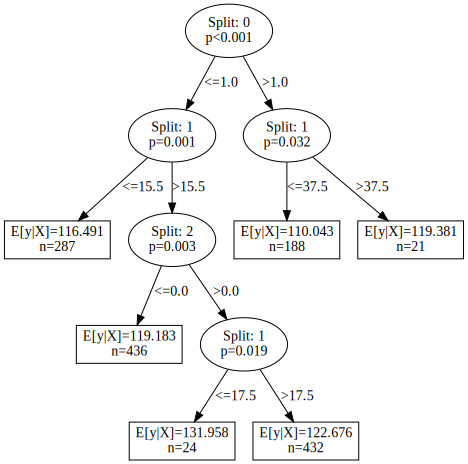

In [74]:
rptree(x,y).plot(Digraph())

In [ ]:
dot = Digraph()
dot.node('A')
dot.node('B')
dot.node('C')
dot.edge('A','B')
dot.edge('A','C')
dot

 Split on 0 at 1.0
L Split on 1 at 15.5
LL Terminal: E[y|X]=116.491 n=287
LR Split on 2 at 0.0
LRL Terminal: E[y|X]=119.183 n=436
LRR Split on 1 at 17.5
LRRL Terminal: E[y|X]=131.958 n=24
LRRR Terminal: E[y|X]=122.676 n=432
R Split on 1 at 37.5
RL Terminal: E[y|X]=110.043 n=188
RR Terminal: E[y|X]=119.381 n=21


/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice
  del sys.path[0]
/home/jason/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jason/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


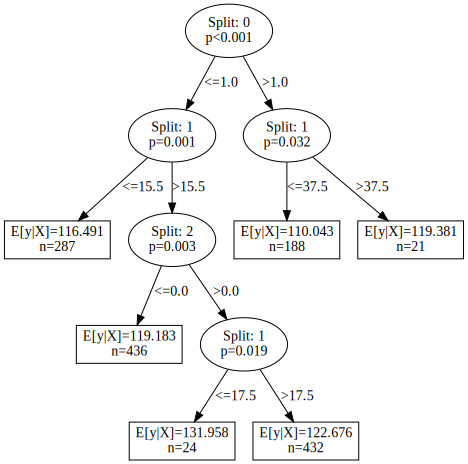

In [16]:
dot = Digraph()
rpart(x,y)
dot

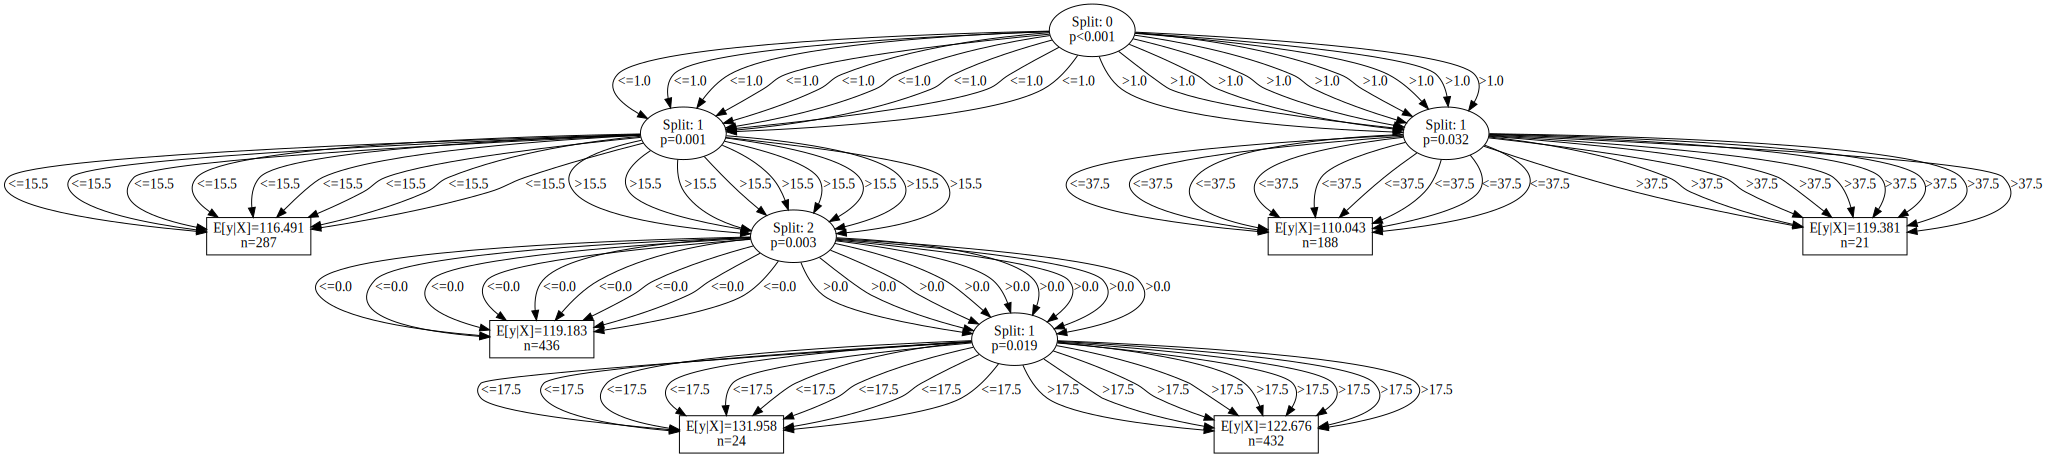

In [61]:
rptree(x,y).plot()

In [1]:

def rpartbin(x,y,level=""):
    dot.node(level)
    splits = []
    RSSes = []
    for i in range(x.shape[1]):
        xuse = x[:,i]
        RSS = []
        for item in np.unique(xuse):
            y1 = y[xuse<=item]
            y2 = y[xuse>item]
            v1 = y1.var()*len(y1)
            v2 = y2.var()*len(y2)
            if np.isnan(v2): v2 = 0
            RSS += [v1+v2]
        splitrow = np.array(RSS).argmin()
        splits += [np.unique(xuse)[splitrow]]
        RSSes += [RSS[splitrow]]
    rchoose = np.array(RSSes).argmin()
    xuse = x[:,rchoose]
    split = splits[rchoose]
    xtmp = (xuse<=split).astype(int).reshape(-1,1)
    pvalue = lm(xtmp,y).pval[1]
    if pvalue>=0.05:
        print(level,"Terminal: E[y|X]="+str(np.round(y.mean(),3))+" n="+str(y.shape[0]))
        fig = plt.figure(figsize=(1,1))
        plt.bar(np.array(0),np.array(y.mean()))
        plt.xticks([0],['y'])
        plt.ylim(0,1)
        os.remove('tmp_'+level+'.png')
        plt.savefig('tmp_'+level+'.png')
        plt.close(fig)
        dot.node(level,label="",image='tmp_'+level+'.png',shape='box')
    else:
        y1 = y[xuse<=split]
        y2 = y[xuse>split]
        x1 = x[xuse<=split,:]
        x2 = x[xuse>split,:]
        dot.node(level,'Split: '+str(rchoose)+'\np='+str(np.round(pvalue[0],3)))
        print(level,"Split on "+str(rchoose)+" at "+str(split))
        rpartbin(x1,y1,level+'L')
        dot.node(level+'L')
        rpartbin(x2,y2,level+'R')
        dot.node(level+'R')
        dot.edge(level,level+'L','<='+str(split))
        dot.edge(level,level+'R','>'+str(split))

In [12]:
bwght['smokes'] = (bwght['cigs']>0).astype(int)
y = bwght['smokes'].values.reshape(-1,1)
x = ['faminc','white','male']
x = [bwght[item] for item in x]
x = pd.concat(x,1).values


In [14]:
plt.ioff()
import os

 Split on 0 at 22.5
L Split on 0 at 12.5
LL Split on 1 at 0.0
LLL Terminal: E[y|X]=0.203
LLR Terminal: E[y|X]=0.307
LR Terminal: E[y|X]=0.175
R Split on 0 at 37.5
RL Terminal: E[y|X]=0.128
RR Terminal: E[y|X]=0.061


/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice
  del sys.path[0]
/home/jason/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jason/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


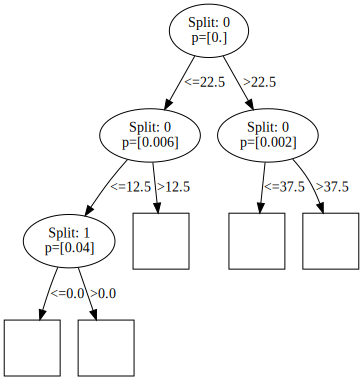

In [18]:
dot = Digraph()
rpartbin(x,y)
dot

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize=(1,2))
plt.bar(np.array(0),np.array(y.mean()))
plt.xticks([0],['y'])
plt.ylim(0,1)
plt.savefig('tmp.png')

